In [81]:
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path

#Preprocessing
from scipy.stats import pearsonr, mode 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

#Models
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans

#plots
import seaborn as sns
from matplotlib import pyplot as plt

#random state
randState = 0

#functions to chose data set and embeddings type:

# Choose data set
def chooseData(data = "BIG5"): #choose big5 or ipip ### dataset paths   
  folder = data.upper() + "/"
  data = data.lower() + "_"
  return folder, data

#Choose embeddings type
def chooseEmb(emb = "USE"): #choose big5 or ipip ### dataset paths   
  embeddings = "questions_embeddings_" + emb.upper() +  ".csv"
  save = "_" + emb.upper() +  ".csv"
  return embeddings, save

#choose prediction model
def predModel(nr=1,par=1):
  if nr == 1:
    model = RidgeClassifier(alpha=par, random_state=randState)
    modName = "RidgeClass"
  elif nr==2:  
    model = KNeighborsClassifier(n_neighbors=par)
    modName = "KNN"
  elif nr==3:
    model = SVC(C=par, random_state=randState)
    modName = "SVC"
  elif nr==4:  
    model = KNeighborsRegressor(n_neighbors=par)
    modName = "KnnReg"
  elif nr == 0:
    model = Ridge(alpha=par, random_state=randState)
    modName = "Ridge"
  print("running {}: ".format(modName))
  return model, modName 

#choose reversed or non reversed data
def getResponses(folder, data, R=1):
  if R == 1:
    res = "responses.csv"
    responses = pd.read_csv("embeddings/"+folder+data+res, index_col=0).T #reversed
    savePath = "results/"+folder+"reversed/"
    items_ids = responses.columns
    items = responses.iloc[0,:].values
    if "item" in responses or "item" in responses.index:
      responses = responses.drop(["item"], axis=0)
  else:
    res = "responses_nonReversed.csv"
    responses = pd.read_csv("embeddings/"+folder+data+res, index_col=0).T #reversed
    responses.columns.name = ""
    savePath = "results/"+folder+"nonReversed/"
    items_ids = responses.columns
    items = responses.iloc[0,:].values
    if "item" in responses or "item" in responses.index:
      responses = responses.drop(["item"], axis=0)

  return responses.astype(float), savePath, items, items_ids 

### Import functions: embeddings & response data


In [82]:
def getEmbeddings(folder, data, embeddings):
  #read in embeddings, order them like the response data and save in vector
  embeddings_df = pd.read_csv("embeddings/" + folder + data +  embeddings,index_col=0)
  question_ids = responses.columns  #get IDs of questions answered

  # only get embeddings of questions having answers in matrix
  embeddings_df = embeddings_df.loc[question_ids,:]
  # save to vector 
  X = embeddings_df.values

  ################################ Preprocess input data::
  #Standardize for regression (wihtout PCA)
  X_stand = pd.DataFrame(StandardScaler().fit_transform(X),index=question_ids) #standardize embeddings
  #With PCA, for regression, 90% variance explained
  X_pca = pd.DataFrame(PCA(0.9, random_state=0).fit_transform(X_stand),index=question_ids) 

  return embeddings_df, X_stand, X_pca

def getData(m):
  
  question_ids = responses.columns
  data_q = X_pca_stand
  
  #choose parameter range
  if m==2 or m==4:  #KNN and KNN Regression
    list_par = [1,5,10,15,30,50] #parameter search
  elif m>=4:  #Random forest, extreme forest, gaussian
    list_par = [data_q.shape[1]] #parameter search
  else:  #Ridge, SVC
    list_par = [10**x for x in range(6)] #parameter search

  constructs = pd.read_csv("embeddings/" + folder + data + "questions_text.csv", encoding = 'utf-8',index_col=0)
  constrAssigned = constructs.loc[data_q.index,:] #only take constructs/encodings of items with embeddings
  constructs_list = constrAssigned.construct.drop_duplicates().values
  data_q = data_q.loc[constrAssigned.index,:] #only keep items that have an assigned construct

  return data_q, constructs_list, list_par, constrAssigned

### Accuracy functions

In [1]:
def correlate(x,y): #pooled items performance
  corr_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct correlation
  l1_constr = pd.DataFrame(np.zeros(shape=(1,len(constructs_list))))  #Dataframe for construct correlation
  questions = x.columns

  for i,nr in zip(constructs_list,range(len(constructs_list))): #go through constructs
    #find questions of current construct
    constrValues = constrAssigned.loc[questions].construct.values       #order the construct lists in the same order as responses/predictions
    constr_idx = np.where(constrValues == i)[0]  
    y_pred_constr = x.iloc[:,constr_idx]   #get predictions
    y_test_constr = y.loc[y_pred_constr.index,questions[constr_idx]]    #get label
    y_pred_match = y_pred_constr.values.flatten('F') #convert to 1D array
    y_test_match = y_test_constr.values.flatten('F')
    y_pred_match = y_pred_match[~pd.isnull(y_test_match)] #drop nan values, important for IPIP
    y_test_match = y_test_match[~pd.isnull(y_test_match)]

    #calculate correlation
    corr = np.round(pearsonr(y_pred_match,y_test_match),2)
    corr_constr.iloc[:,nr] = corr[0]
    l1 = np.round(sum(np.abs(y_pred_match-y_test_match))/len(y_test_match),2)
    l1_constr.iloc[:,nr] = l1

  y_pred = x.values.flatten()
  y_test = y.loc[y_pred_constr.index,:].values.flatten()
  y_pred = y_pred[~pd.isnull(y_test)]
  y_test = y_test[~pd.isnull(y_test)]

  corr_total, pval_total = np.round(pearsonr(y_pred,y_test),3)
  l1_total = np.round(sum(np.abs(y_pred-y_test))/len(y_test),3)
  return list(corr_constr.mean()), corr_total, pval_total, list(l1_constr.mean()), l1_total

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    a = a[~np.isnan(a)] #remove nan
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def corrUserBased(x,y):
  #calculate correlations and p value for every person, then average:
  results = pd.DataFrame(np.full(shape=(x.shape[0],3),fill_value=0),index = x.index,columns=["Correlation","p-value","L1 Loss"])
  
  #new function, much faster, #NOT FOR IPIP, #adjust for p value of averages
  corrVals = x.corrwith(y, 1, method=lambda x, y: np.round(pearsonr(x, y), 6)).fillna(0)
  results.iloc[:,:2] = corrVals.values.tolist()
  results.iloc[:,2] = np.absolute(x - y).sum(1)/x.shape[1] 
  results = results.fillna(0)
  t, pval_total = stats.ttest_1samp(results.Correlation, popmean=0) #get p-value of average correlation tested against 0, #change to make n decimals!
  mean, ci_lower, ci_upper = mean_confidence_interval(results.Correlation)
  return results, [results.Correlation.mean(), pval_total, results['L1 Loss'].mean(), ci_lower, ci_upper, t, results.shape[0]-1]

Load Data

In [84]:
#Choose Data Set:
R = 2           #1: reversed-coded, #2: nonReversed-coded
d = "big5"      #BIG5. 16PF, RIASEC, HSQ, IPIP, IPIP2 (assigned items only)

#best Model (KnnRegression k=5, no reverse-coding):
m = 4          #0: Ridge, #1: RidgeClass, #2:KNN, #3: Kernel SVM (RBF), #4: KNN regression
par = 5
e = 'sentencebert'
model, modelName = predModel(m,par) 

#load path and necessary variables:
folder, data = chooseData(d)        # BIG5, IPIP (all items), IPIP2 (only assigned items), RIASEC, HEXACO, 16PF
embeddings, save = chooseEmb(e)     #USE, BERT, SENTENCEBERT
responses, savePath, items, _ = getResponses(folder, data, R) #1: Reversed, #2: nonReversed
responses = responses.astype(float) #get observed responses as floats
X, X_stand, X_pca_stand = getEmbeddings(folder, data, embeddings)

#get embeddings name:
embName = embeddings.split("_")[2].split(".")[0]

# import required data and labels:
data_q, constructs_list, list_par, constrAssigned = getData(1)

# get predicted responses of chosen model:
total_preds = pd.read_csv(savePath + modelName + "_" + str(par) + "_" + embName + "_responses.csv", index_col=0)
total_preds.index = total_preds.index.map(str)
total_preds = total_preds.astype(float)

#get performance:
corr, means = corrUserBased(total_preds, responses)

# create folder for saving human raters data (files to run create survey)
Path("human_studies/" + d.upper()).mkdir(parents=True, exist_ok = True)
h_path = "human_studies/" + d.upper() + "/" + d

running KnnReg: 


D:\Programmes\Anaconda\envs\questionnaire\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Find Target Participants (0th-100th percentiles in 60 steps)

In [85]:
error = 0.0001 # for rounding errors
sorted = corr.sort_values("Correlation")
S = sorted.Correlation
P = sorted['p-value']
percentage_rank = S.rank(method="max", pct=True)
sorted["percentile"] = percentage_rank

nr_targets = 60
percentiles = np.linspace(0, 1, nr_targets)
verbose = False

ids = []

for q in percentiles:
  idx = S.index[percentage_rank >= q-error]
  ids.append(idx[0])
    
  if verbose==1:
      print("Rank: " + str(round(percentage_rank[idx[0]], 3)))
      print('Target ID: ' + idx[0])
      print("Correlation: " + str(S[idx[0]]))
      print("p-value: " + str(P[idx[0]]))
      CI = r_confidence_interval(S[idx[0]], 0.95, responses.shape[1])
      print("CI: [" + str(CI[0]) + ", " + str(CI[1]) + "]")
      print("\n")

# Save Targets in dataframe
targets_ranked = sorted.loc[ids]
targets_ranked.insert(0, "target_nr", list(range(2,62)))
targets_responses = responses.loc[ids]
targets_ranked_nr = ["Field " + str(i) for i in range(2,62)]

# Get responses for each target
targets_data = pd.merge(targets_ranked, targets_responses, left_index=True, right_index=True).drop(labels = ["L1 Loss"], axis = 1)
targets_data_processed = targets_data.drop(["target_nr", "Correlation", "p-value", "percentile"], axis=1).T
targets_data_processed.columns = list(targets_ranked_nr)
targets_data_processed.index.name = "question-id"

# Save each target separately
# targets_data.to_csv(h_path + "_targets_data.csv") # save to files

Extract and save train/test folds

In [88]:
kf = KFold(n_splits=10, random_state=randState, shuffle=True)
questions = list(kf.split(data_q))
questions = [(x+1,y+1) for x,y in questions]
question_texts = pd.read_csv("embeddings/BIG5/" + "big5_questions_text.csv", index_col=0) #get question texts

# merge response data (sorted targets) with question texts for qualtrics import
target_data_full = pd.merge(question_texts["grammartical_item"], targets_data_processed, on="question-id")
target_data_full = target_data_full.rename(columns={'grammartical_item': 'full_item'})
target_data_full.full_item = target_data_full.full_item.str.capitalize()
target_data_full.to_csv(h_path + "_full_targets_questions.csv")

folds = []
for nr, fold in enumerate(questions):
    train = questions[nr][0]
    test = questions[nr][1]
    folds.append([nr+1, train, test])
    target_data_fold_train = target_data_full.iloc[train-1]
    target_data_fold_test  = target_data_full.iloc[test-1]
    target_data_fold_train.to_csv(h_path + "_train_fold_" + str(nr+1) + ".csv")
    target_data_fold_test.to_csv(h_path + "_test_fold_" + str(nr+1) + ".csv")
    
df_folds = pd.DataFrame(folds, columns=["fold_nr", "train_items", "test_items"])
# df_folds.to_csv(h_path + "_question_folds.csv", index=False) # save to files

# Compare model to human data (analysis)

In [89]:
# load target responses (original data)
targets_data = pd.read_csv(h_path + "_targets_data.csv", index_col=0)
# load human rater data (revised human study)
human_data = pd.read_csv(h_path + "_qualtrics_cleaned.csv", index_col = 0)
# load model predictions (original prediction model)
model_data = total_preds.loc[targets_data.index]
model_data = pd.merge(model_data, targets_data.target_nr, left_index=True, right_index=True) # add target_nr

# function to compare target and fold wise, save correlations in array
def predictionPerformance(targets_data, human_data, model_data):
    rows = []
    for target in targets_data.target_nr: #iterate over targets
        for fold in range(10): #iterate over folds
            test_items_idx = df_folds.loc[df_folds.fold_nr==fold+1, "test_items"].iloc[0]
            test_items_names = ["q" + str(x) for x in test_items_idx]
            true_x  = targets_data.loc[targets_data.target_nr == target, test_items_names].iloc[0]
            model_x = model_data.loc[model_data.target_nr == target, test_items_names].iloc[0]
            corr_model, p_model = pearsonr(true_x, model_x)
            rows.append([corr_model, p_model, target, fold+1, "Model"])
            if any((human_data.target == target) & (human_data.fold == fold+1)):
                human_x = human_data.loc[(human_data.target == target) & (human_data.fold == fold+1), test_items_names].iloc[0]
                nas = np.logical_or(np.isnan(true_x), np.isnan(human_x))   # in case nan are in vector
                corr_human, p_human = pearsonr(true_x[~nas], human_x[~nas])
                rows.append([corr_human, p_human, target, fold+1, "Human"])
            else:
                corr_human, p_human = [np.nan, np.nan]
                rows.append([corr_human, p_human, target, fold+1, "Human"])

    df_comparison = pd.DataFrame(rows, columns=["Correlation", "pvalue", "target", "fold", "Predictor"])
    return df_comparison

def targetComparison(targets_data, human_data, model_data):
    targets_h = []
    targets_m = []
    for target in targets_data.target_nr: #iterate over targets
        innerlist_h = []
        innerlist_m = []
        for fold in range(10): #iterate over folds
            test_items_idx = df_folds.loc[df_folds.fold_nr==fold+1, "test_items"].iloc[0]
            test_items_names = ["q" + str(x) for x in test_items_idx]
            true_x  = targets_data.loc[targets_data.target_nr == target, test_items_names].iloc[0]
            model_x = model_data.loc[model_data.target_nr == target, test_items_names].iloc[0]
            corr_model, p_model = pearsonr(true_x, model_x)
            innerlist_m.append(corr_model)
            if any((human_data.target == target) & (human_data.fold == fold+1)):
                human_x = human_data.loc[(human_data.target == target) & (human_data.fold == fold+1), test_items_names].iloc[0]
                nas = np.logical_or(np.isnan(true_x), np.isnan(human_x))   # in case nan are in vector
                corr_human, p_human = pearsonr(true_x[~nas], human_x[~nas])
                innerlist_h.append(corr_human)
            else:
                corr_human, p_human = [np.nan, np.nan]
                innerlist_h.append(corr_human)
        targets_m.append(innerlist_m)
        targets_h.append(innerlist_h)

    return targets_h, targets_m

targets_h, targets_m = targetComparison(targets_data, human_data, model_data)
df_comparison = predictionPerformance(targets_data, human_data, model_data)

D:\Programmes\Anaconda\envs\questionnaire\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Programmes\Anaconda\envs\questionnaire\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Programmes\Anaconda\envs\questionnaire\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Programmes\Anaconda\envs\questionnaire\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
D:\Programmes\Anaconda\envs\questionnaire\Lib\site-packages\scip

### Performance averages and distributions

Get average performance and test for significance (against zero)

In [100]:
from numpy import nanmean
#humans
h = [x for s in targets_h for x in s]
ttest_h = stats.ttest_1samp(h, 0, nan_policy="omit")
t_h = round(ttest_h[0], 3)
p_h = round(ttest_h[1], 4)

#model
c = [x for s in targets_m for x in s]
ttest_c = stats.ttest_1samp(c, 0, nan_policy="omit")
t_c = round(ttest_c[0], 3)
p_c = round(ttest_c[1], 4)

print("Human raters:")
print(nanmean(h))
print(t_h)
print(p_h)
print(len(h))

print("\nModel:")
print(nanmean(c))
print(t_c)
print(p_c)
print(len(c))

Human raters:
0.4887195616969424
35.355
0.0
600

Model:
0.4701293085638519
38.393
0.0
600


Welch Test: Are the human and model average performances significantly different from each other?

In [91]:
model = df_comparison[df_comparison.Predictor == "Model"].dropna()
humans = df_comparison[df_comparison.Predictor == "Human"].dropna()

def welch_t_test(mu1, s1, N1, mu2, s2, N2):
  # Construct arrays to make calculations more succint.
  N_i = np.array([N1, N2])
  dof_i = N_i - 1
  v_i = np.array([s1, s2]) ** 2
  # Calculate t-stat, degrees of freedom, use scipy to find p-value.
  t = (mu1 - mu2) / np.sqrt(np.sum(v_i / N_i))
  dof = (np.sum(v_i / N_i) ** 2) / np.sum((v_i ** 2) / ((N_i ** 2) * dof_i))
  p = stats.distributions.t.sf(np.abs(t), dof) * 2
  return t, p, dof

# 2 sample independent welch test 
welch_stat = welch_t_test(np.mean(humans.Correlation), np.std(humans.Correlation, ddof=1), humans.Correlation.size,
                           np.mean(model.Correlation), np.std(model.Correlation, ddof=1), model.Correlation.size)

print(welch_stat) #not significantly different! absolute difference very small too

(1.0066758282931239, 0.3143036777298694, 1142.8039980956034)


Alternatively, use a regression model to test difference between models

In [106]:
#alternatively run regression:
import statsmodels.formula.api as sm
model = sm.ols(formula = "Correlation ~ Predictor", data=df_comparison)
res = model.fit()
A = np.identity(len(res.params))[1:,:]
print(res.summary())
print('R2: ', res.rsquared)
print(res.f_test(A))  
#no difference and does not contribute to model prediction

                            OLS Regression Results                            
Dep. Variable:            Correlation   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.018
Date:                Fri, 21 Apr 2023   Prob (F-statistic):              0.313
Time:                        02:22:12   Log-Likelihood:                -306.77
No. Observations:                1169   AIC:                             617.5
Df Residuals:                    1167   BIC:                             627.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.4887      0

Look into distribution (are most correlations positive? large?)

In [105]:
print(np.mean(df_comparison.Correlation[df_comparison.Predictor == "Human"]>0)) # 85% positive

print(np.mean(df_comparison.Correlation[df_comparison.Predictor == "Model"]>0)) # 91% positive

0.8533333333333334
0.9133333333333333


## Plots

### Distributions

Text(0.5, 0, 'Correlation')

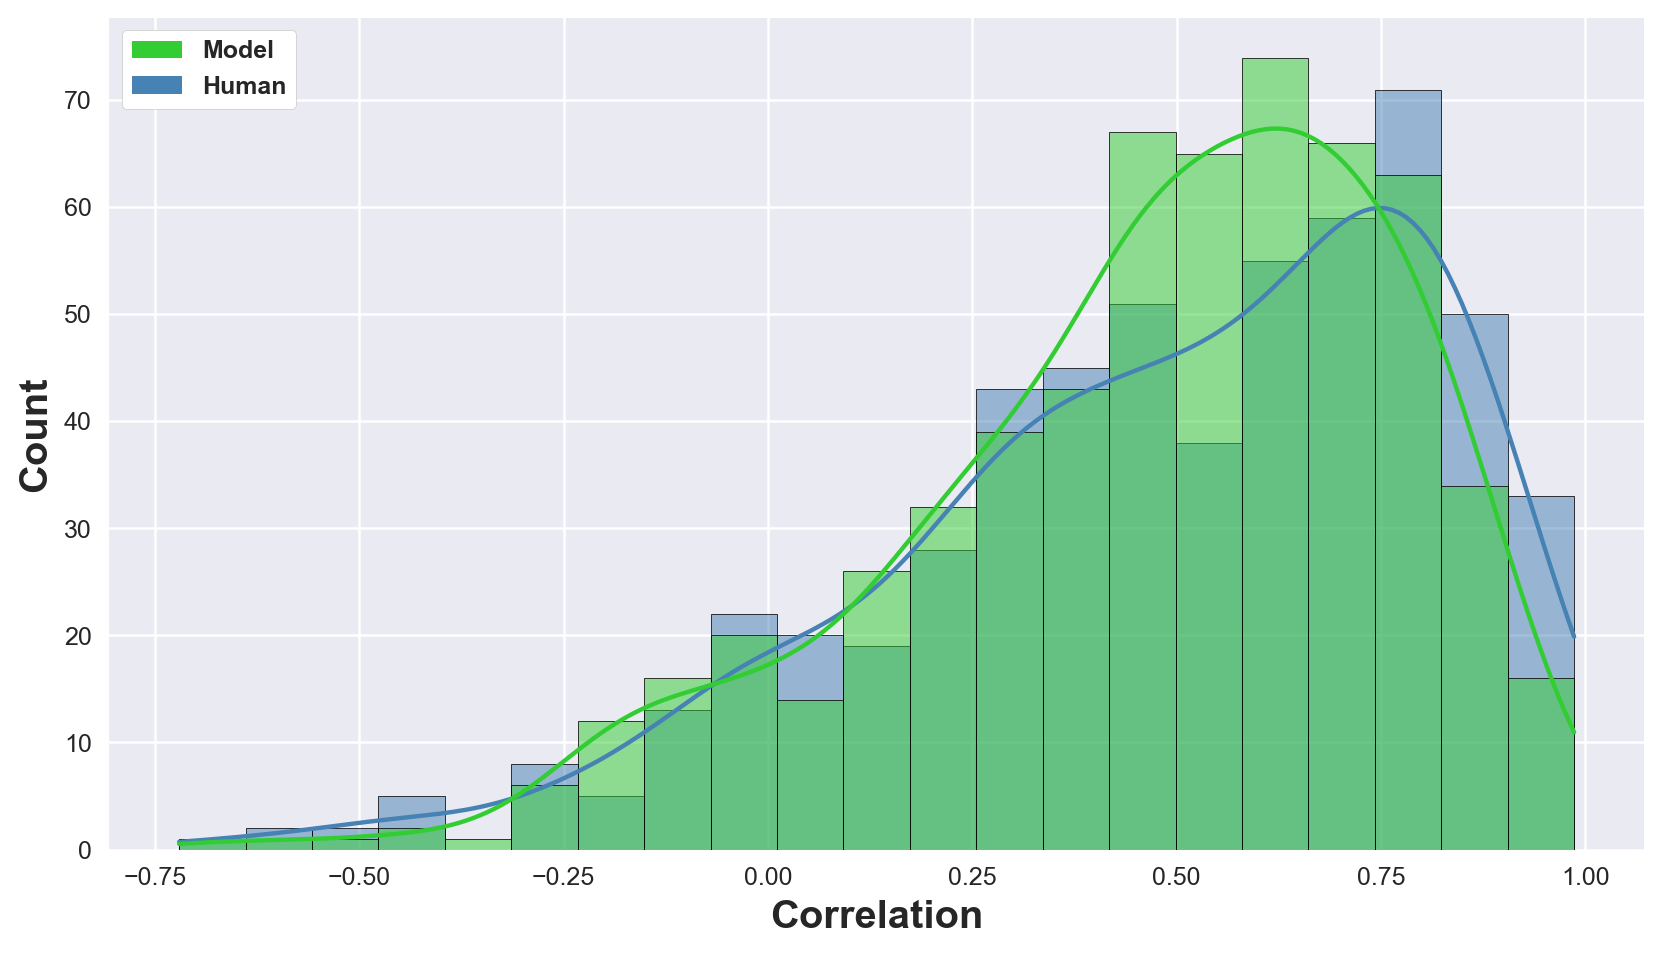

In [107]:
#Add the distribution plots for each data set:
#loop over data, see main file
fig  = plt.figure(figsize=(11, 6), dpi= 180)
palette=["limegreen","steelblue"]
ax = sns.histplot(df_comparison, x="Correlation", kde=True, hue="Predictor", palette = palette)
from matplotlib.patches import Patch
handles = [Patch(facecolor=item) for item in palette]
labels = df_comparison.Predictor.unique().tolist()
ax.legend(loc = "upper left", handles = handles, labels = labels, frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold'})
ax.set_ylabel('Count', fontweight = "bold", fontsize = 16)
ax.set_xlabel('Correlation', fontweight = "bold", fontsize = 16)

### Barplots (compare average performance)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6')])

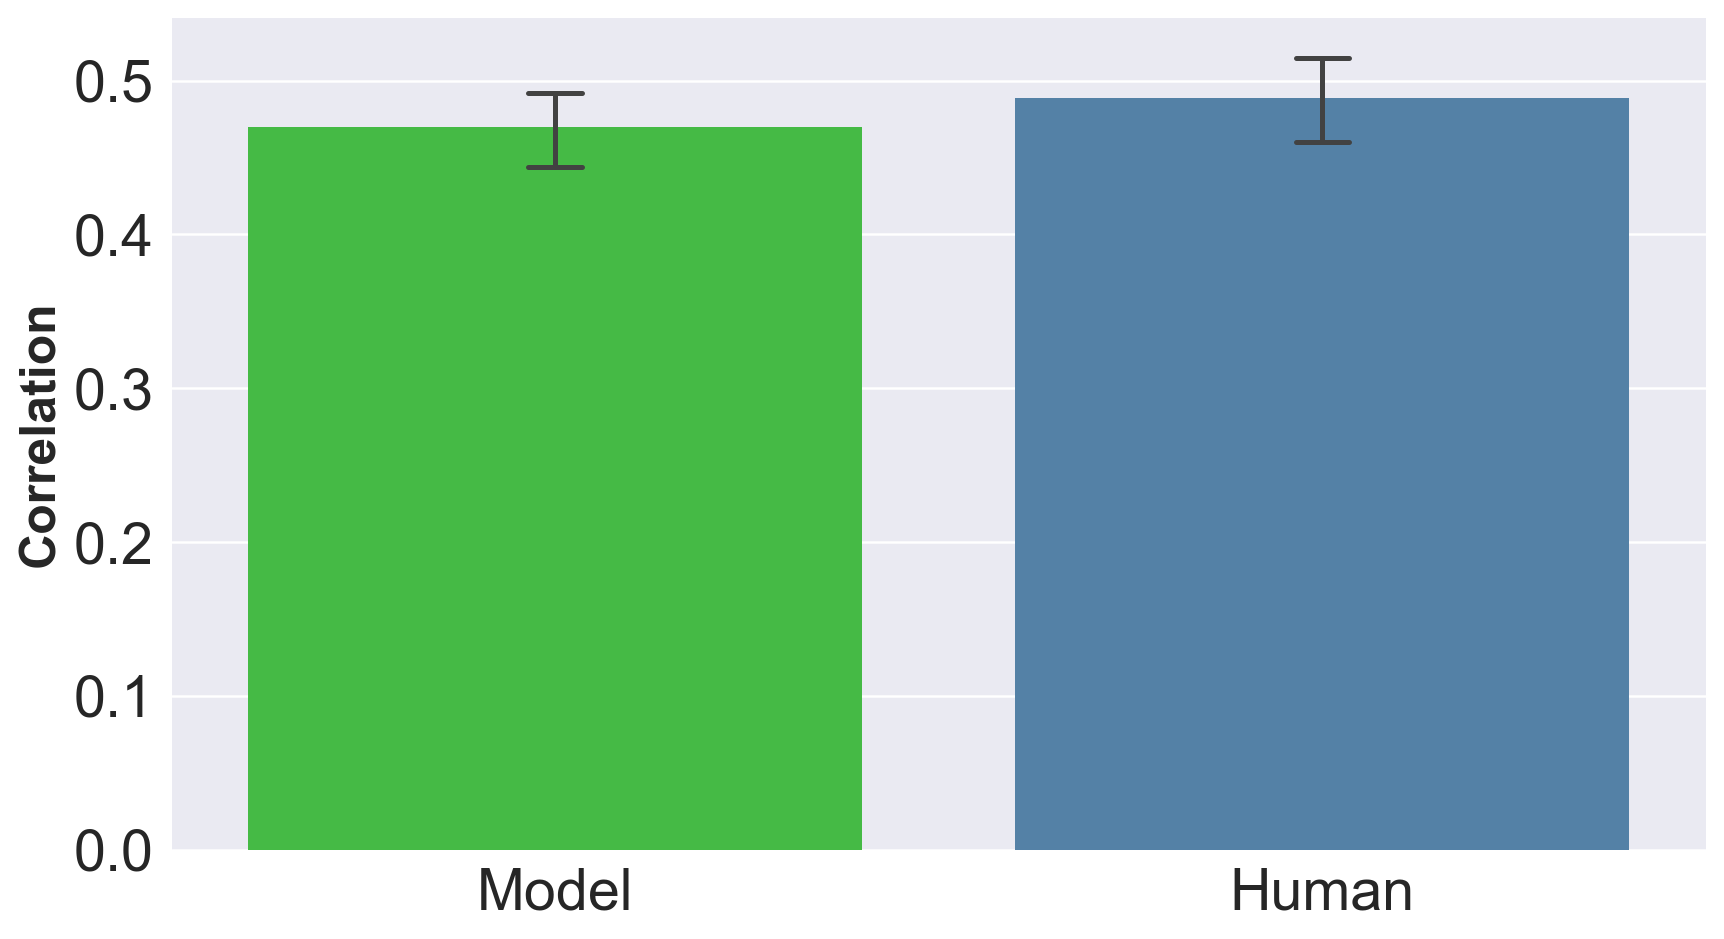

In [108]:
# create barplots (comparing average performances)
# loop over data (see main file)
fig  = plt.figure(figsize=(11, 6), dpi= 180)
ax = sns.barplot(y='Correlation', x='Predictor', orient='v', data=df_comparison, errorbar=('ci', 95), 
                 palette=["limegreen","steelblue"], capsize=0.07, errwidth=2)
plt.ylabel("Correlation", fontweight='bold', fontsize=20)
plt.xlabel("", fontweight='bold', fontsize=20, labelpad=-13)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)

### Create scatterplot (model vs humans)

C:\Users\suhai\AppData\Local\Temp\ipykernel_10508\527156596.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


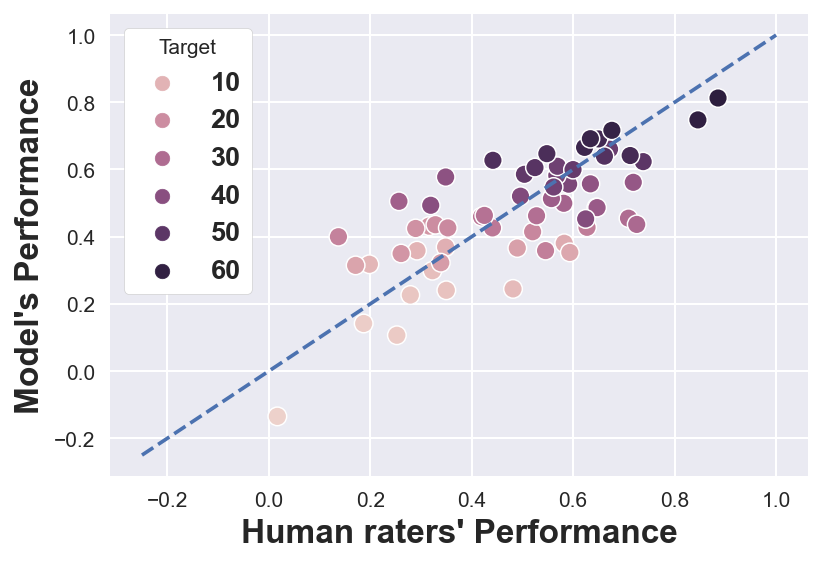

In [63]:
# Looks balanced -> both equally good
# Loop over all data -> create targets_* from each dataset
rows = []
targets=list(range(2,62))
for i in range(60):
  humans = nanmean(targets_h[i])
  model = nanmean(targets_m[i])
  target = targets[i]
  rows.append([humans, model, target])
df = pd.DataFrame(rows, columns=["humans", "model", "target"])
# color_mapping = {'25th Percentile':'red', '50th Percentile':'white', '75th Percentile':'blue'}
                                          
plt.style.use("seaborn")
fig, ax = plt.subplots(figsize=(6, 4), dpi = 150) #figure specs
sns.scatterplot(data=df, x="humans", y="model", hue="target", s=80, alpha=1.0)

# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model\'s Performance', fontweight = "bold", fontsize=16)
ax.set_xlabel('Human raters\' Performance', fontweight = "bold", fontsize=16)
ax.legend(loc="upper left", frameon = True, framealpha = 1.0, facecolor='white', prop={'weight':'bold','size':13}, title="Target")
ax.plot((-0.25, 1),(-0.25, 1), ls='--')

Correlation of human and model performance

In [110]:
pearsonr(df.humans, df.model)

PearsonRResult(statistic=0.7386559790083895, pvalue=1.619697227407521e-11)